In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys

import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [3]:
import joblib
data_path='/content/drive/My Drive/fusion/video/data_set_fusion/expert5/'
train_path_name=joblib.load(data_path+'train/video_train_path')
valid_path_name=joblib.load(data_path+'valid/video_valid_path')
test_path_name=joblib.load(data_path+'test/video_test_path')
#test_path_name

In [4]:
#load video name train and test

train_label = joblib.load(data_path+'train/labels_train')
y_valid= joblib.load(data_path+'valid/labels_valid')
y_test= joblib.load(data_path+'test/labels_test')

In [5]:
len(train_label),len(y_valid),len(y_test)

(1653, 207, 207)

In [6]:
test_path=[]

for i in test_path_name:
  s=i.split('/')[6]
  s=s.split('-')
  s[0]='03'
  s[6]=s[6].split('.')[0]
  if(s[1]=='01'):
    kind='speech'
  else:
    kind='song'
  actor=s[-1]
  listToStr = '-'.join(map(str, s))
  listToStr+=".wav"
  path='/content/drive/My Drive/RAVDESS_'+kind+'/Actor_'+s[-1]+'/'+listToStr
  test_path.append(path)

In [7]:
train_path=[]

for i in train_path_name:
  s=i.split('/')[6]
  s=s.split('-')
  s[0]='03'
  s[6]=s[6].split('.')[0]
  if(s[1]=='01'):
    kind='speech'
  else:
    kind='song'
  actor=s[-1]
  listToStr = '-'.join(map(str, s))
  listToStr+=".wav"
  path='/content/drive/My Drive/RAVDESS_'+kind+'/Actor_'+s[-1]+'/'+listToStr
  train_path.append(path)

In [8]:
valid_path=[]

for i in valid_path_name:
  s=i.split('/')[6]
  s=s.split('-')
  s[0]='03'
  s[6]=s[6].split('.')[0]
  if(s[1]=='01'):
    kind='speech'
  else:
    kind='song'
  actor=s[-1]
  listToStr = '-'.join(map(str, s))
  listToStr+=".wav"
  path='/content/drive/My Drive/RAVDESS_'+kind+'/Actor_'+s[-1]+'/'+listToStr
  valid_path.append(path)


In [9]:
#radvass speech and song
import time
import os
import librosa
from librosa import display
import matplotlib.pyplot as plt

count=0
x_test = []
X_valid=[]
x_train=[]
start_time = time.time()
for path in valid_path :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        X_valid.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue

for path in test_path :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        x_test.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue

for path in train_path :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        x_train.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 169.79550075531006 seconds ---


In [10]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from keras.models import InputLayer

model = Sequential(InputLayer((40,1)))
model.add(BatchNormalization())

model.add(Conv1D(128, 12,padding='same', ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(5)))


model.add(Conv1D(256,12,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.Adam(lr=0.0002)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [11]:
import numpy as np
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
X_valid= np.expand_dims(X_valid, axis=2)

In [12]:
x_traincnn.shape, x_testcnn.shape , X_valid.shape
#1861

((1653, 40, 1), (207, 40, 1), (207, 40, 1))

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
# Create an Instance of Early Stopping Callback.
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 75, mode = 'min', restore_best_weights = True)

cnnhistory=model.fit(x_traincnn, train_label, batch_size=16, epochs=500 , shuffle = True, 
                     validation_data=(X_valid, y_valid))

Epoch 1/500
104/104 [==============================] - 3s 7ms/step - loss: 1.9583 - accuracy: 0.2619 - val_loss: 2.2832 - val_accuracy: 0.1836
Epoch 2/500
104/104 [==============================] - 0s 5ms/step - loss: 1.7188 - accuracy: 0.3067 - val_loss: 3.2716 - val_accuracy: 0.1836
Epoch 3/500
104/104 [==============================] - 0s 5ms/step - loss: 1.6300 - accuracy: 0.3436 - val_loss: 3.3806 - val_accuracy: 0.1836
Epoch 4/500
104/104 [==============================] - 0s 5ms/step - loss: 1.5684 - accuracy: 0.3751 - val_loss: 2.6980 - val_accuracy: 0.1836
Epoch 5/500
104/104 [==============================] - 0s 5ms/step - loss: 1.5257 - accuracy: 0.3721 - val_loss: 1.8975 - val_accuracy: 0.1981
Epoch 6/500
104/104 [==============================] - 0s 5ms/step - loss: 1.4922 - accuracy: 0.3969 - val_loss: 1.5850 - val_accuracy: 0.3285
Epoch 7/500
104/104 [==============================] - 0s 5ms/step - loss: 1.4905 - accuracy: 0.4023 - val_loss: 1.4583 - val_accuracy: 0.3720

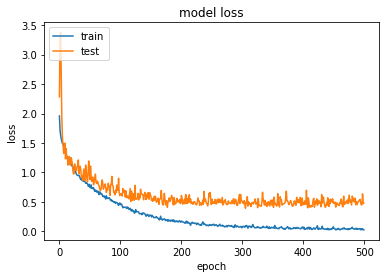

In [15]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

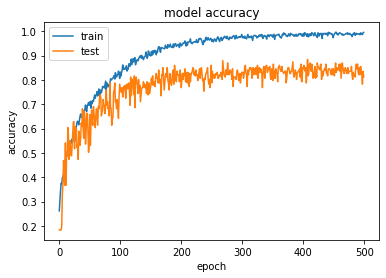

In [16]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [17]:
predictions = model.predict(x_testcnn)

In [18]:
predictions

array([[3.1205434e-09, 1.8780388e-07, 9.7123903e-01, 2.8477982e-02,
        2.1265022e-07, 2.8255812e-04],
       [2.8146801e-18, 9.9999905e-01, 7.5013105e-07, 1.8442246e-07,
        1.8121093e-14, 1.0111507e-14],
       [2.9752241e-03, 1.9900364e-04, 5.2369440e-01, 8.5086338e-02,
        2.0554356e-01, 1.8250148e-01],
       ...,
       [1.8429887e-06, 1.2571205e-10, 9.3627052e-05, 4.1675605e-05,
        2.7027580e-01, 7.2958702e-01],
       [1.5790745e-04, 1.2335242e-06, 2.6524384e-04, 4.0220129e-05,
        1.2794102e-04, 9.9940741e-01],
       [3.3736549e-07, 4.4403858e-08, 2.6451983e-03, 5.4643501e-04,
        9.9290681e-01, 3.9011340e-03]], dtype=float32)

In [19]:
y_test

array([2, 1, 4, 4, 0, 5, 4, 1, 5, 3, 3, 2, 0, 5, 2, 2, 3, 3, 2, 1, 2, 4,
       1, 5, 4, 2, 3, 0, 5, 3, 0, 2, 2, 3, 3, 4, 4, 5, 1, 4, 0, 0, 4, 4,
       0, 2, 2, 2, 3, 0, 4, 2, 5, 5, 3, 1, 3, 3, 1, 0, 5, 4, 5, 3, 3, 5,
       5, 4, 5, 5, 5, 2, 5, 5, 4, 4, 5, 2, 3, 1, 4, 5, 1, 4, 2, 0, 1, 2,
       0, 0, 5, 5, 2, 2, 4, 1, 5, 0, 1, 3, 2, 2, 2, 1, 4, 1, 3, 1, 4, 1,
       4, 0, 4, 4, 4, 2, 5, 5, 0, 4, 4, 1, 1, 2, 2, 2, 1, 5, 2, 4, 4, 3,
       4, 1, 5, 2, 4, 2, 2, 0, 3, 3, 5, 3, 2, 0, 1, 5, 2, 0, 4, 0, 1, 5,
       2, 2, 3, 1, 4, 5, 5, 3, 5, 2, 2, 1, 1, 4, 5, 1, 3, 4, 3, 0, 5, 5,
       2, 1, 0, 4, 2, 4, 4, 4, 1, 2, 3, 4, 4, 2, 4, 5, 2, 1, 5, 1, 3, 5,
       5, 3, 3, 5, 4, 4, 4, 5, 4])

In [20]:
new_Ytest = y_test.astype(int)

In [21]:
new_Ytest

array([2, 1, 4, 4, 0, 5, 4, 1, 5, 3, 3, 2, 0, 5, 2, 2, 3, 3, 2, 1, 2, 4,
       1, 5, 4, 2, 3, 0, 5, 3, 0, 2, 2, 3, 3, 4, 4, 5, 1, 4, 0, 0, 4, 4,
       0, 2, 2, 2, 3, 0, 4, 2, 5, 5, 3, 1, 3, 3, 1, 0, 5, 4, 5, 3, 3, 5,
       5, 4, 5, 5, 5, 2, 5, 5, 4, 4, 5, 2, 3, 1, 4, 5, 1, 4, 2, 0, 1, 2,
       0, 0, 5, 5, 2, 2, 4, 1, 5, 0, 1, 3, 2, 2, 2, 1, 4, 1, 3, 1, 4, 1,
       4, 0, 4, 4, 4, 2, 5, 5, 0, 4, 4, 1, 1, 2, 2, 2, 1, 5, 2, 4, 4, 3,
       4, 1, 5, 2, 4, 2, 2, 0, 3, 3, 5, 3, 2, 0, 1, 5, 2, 0, 4, 0, 1, 5,
       2, 2, 3, 1, 4, 5, 5, 3, 5, 2, 2, 1, 1, 4, 5, 1, 3, 4, 3, 0, 5, 5,
       2, 1, 0, 4, 2, 4, 4, 4, 1, 2, 3, 4, 4, 2, 4, 5, 2, 1, 5, 1, 3, 5,
       5, 3, 3, 5, 4, 4, 4, 5, 4])

In [22]:
preds1=predictions.argmax(axis=1)
preds1

array([2, 1, 2, 4, 3, 5, 4, 1, 5, 5, 3, 2, 3, 5, 2, 2, 1, 3, 2, 1, 2, 4,
       1, 3, 4, 2, 3, 4, 3, 3, 3, 3, 2, 3, 3, 4, 4, 5, 1, 4, 1, 0, 4, 4,
       0, 2, 2, 2, 3, 0, 4, 2, 5, 5, 5, 1, 3, 3, 1, 0, 2, 4, 5, 3, 3, 5,
       4, 4, 3, 5, 5, 2, 5, 5, 2, 4, 3, 2, 3, 1, 4, 4, 3, 5, 2, 0, 1, 2,
       0, 0, 5, 5, 2, 2, 4, 1, 5, 0, 1, 3, 2, 2, 5, 1, 2, 1, 3, 1, 4, 1,
       4, 1, 4, 4, 2, 5, 5, 2, 0, 4, 4, 1, 3, 2, 2, 5, 1, 5, 2, 4, 4, 3,
       4, 2, 5, 1, 4, 2, 2, 0, 3, 3, 5, 3, 2, 1, 1, 5, 2, 0, 4, 0, 2, 5,
       2, 2, 5, 1, 4, 2, 5, 3, 5, 2, 2, 1, 1, 4, 5, 1, 3, 4, 4, 0, 5, 5,
       2, 1, 0, 4, 2, 4, 4, 4, 1, 2, 3, 4, 2, 5, 4, 3, 2, 1, 5, 1, 3, 5,
       5, 3, 3, 5, 4, 4, 5, 5, 4])

In [23]:
abc = preds1.astype(int).flatten()

In [24]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(new_Ytest, abc) 
c

array([[14,  3,  0,  3,  1,  0],
       [ 0, 26,  2,  2,  0,  0],
       [ 0,  1, 35,  1,  0,  4],
       [ 0,  1,  0, 24,  1,  3],
       [ 0,  0,  5,  0, 38,  2],
       [ 0,  0,  3,  5,  2, 31]])

In [25]:
y_test

array([2, 1, 4, 4, 0, 5, 4, 1, 5, 3, 3, 2, 0, 5, 2, 2, 3, 3, 2, 1, 2, 4,
       1, 5, 4, 2, 3, 0, 5, 3, 0, 2, 2, 3, 3, 4, 4, 5, 1, 4, 0, 0, 4, 4,
       0, 2, 2, 2, 3, 0, 4, 2, 5, 5, 3, 1, 3, 3, 1, 0, 5, 4, 5, 3, 3, 5,
       5, 4, 5, 5, 5, 2, 5, 5, 4, 4, 5, 2, 3, 1, 4, 5, 1, 4, 2, 0, 1, 2,
       0, 0, 5, 5, 2, 2, 4, 1, 5, 0, 1, 3, 2, 2, 2, 1, 4, 1, 3, 1, 4, 1,
       4, 0, 4, 4, 4, 2, 5, 5, 0, 4, 4, 1, 1, 2, 2, 2, 1, 5, 2, 4, 4, 3,
       4, 1, 5, 2, 4, 2, 2, 0, 3, 3, 5, 3, 2, 0, 1, 5, 2, 0, 4, 0, 1, 5,
       2, 2, 3, 1, 4, 5, 5, 3, 5, 2, 2, 1, 1, 4, 5, 1, 3, 4, 3, 0, 5, 5,
       2, 1, 0, 4, 2, 4, 4, 4, 1, 2, 3, 4, 4, 2, 4, 5, 2, 1, 5, 1, 3, 5,
       5, 3, 3, 5, 4, 4, 4, 5, 4])

In [26]:
loss, acc =model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

7/7 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.8116
Restored model, accuracy: 81.16%


In [27]:
loss, acc =model.evaluate(x_traincnn,train_label )
print("Restored model train, accuracy: {:5.2f}%".format(100*acc))

52/52 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.9988
Restored model train, accuracy: 99.88%


              precision    recall  f1-score   support

           0       1.00      0.67      0.80        21
           1       0.84      0.87      0.85        30
           2       0.78      0.85      0.81        41
           3       0.69      0.83      0.75        29
           4       0.90      0.84      0.87        45
           5       0.78      0.76      0.77        41

    accuracy                           0.81       207
   macro avg       0.83      0.80      0.81       207
weighted avg       0.82      0.81      0.81       207

----accuracy score 81.15942028985508 ----


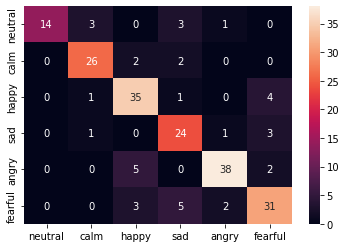

In [28]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(new_Ytest,abc))

acc = float(accuracy_score(new_Ytest,abc))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(new_Ytest,abc)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral','calm', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [29]:
model_path='/content/drive/My Drive/fusion/final_audio/model/expert5/'

In [30]:
model_file_name = f'/content/drive/My Drive/fusion/final_audio/model/expert5/best_CNN_model___Loss_{loss}___Accuracy_{acc}.h5'

# Save the Model.
model.save(model_file_name)

In [31]:
model.save(model_path+'best_CNN_model')
print("MODEL SAVED")

INFO:tensorflow:Assets written to: /content/drive/My Drive/fusion/final_audio/model/expert5/best_CNN_model/assets
MODEL SAVED


In [32]:
# serialize model to JSON
model_json = model.to_json()
with open(model_path+"best_CNN_model.json", "w") as json_file:
    json_file.write(model_json)

In [33]:
prediction_valid = model.predict(X_valid)
prediction_valid

array([[4.5626187e-11, 1.5412485e-18, 5.0129736e-09, 2.9184191e-13,
        1.0000000e+00, 8.2541725e-09],
       [2.9946900e-08, 8.1384323e-06, 9.9983704e-01, 4.3672827e-08,
        2.1542212e-06, 1.5258172e-04],
       [8.7330438e-05, 2.4959479e-09, 3.4235523e-03, 9.9442357e-01,
        1.6289781e-03, 4.3653496e-04],
       ...,
       [2.6389274e-03, 1.0547272e-02, 1.8555391e-05, 9.0185273e-03,
        3.8417457e-11, 9.7777677e-01],
       [1.2616755e-04, 3.2086942e-07, 1.5323417e-03, 1.1387113e-03,
        4.1005812e-03, 9.9310195e-01],
       [3.8016483e-06, 4.3079024e-15, 2.5239578e-07, 9.3598028e-06,
        1.1044084e-04, 9.9987602e-01]], dtype=float32)

In [34]:
prediction_train = model.predict(x_traincnn)
prediction_train

array([[7.4526836e-04, 9.9846989e-01, 1.1556148e-04, 6.4935425e-04,
        2.1395745e-06, 1.7916058e-05],
       [9.9367368e-01, 4.4171946e-05, 3.5689294e-03, 1.0132977e-03,
        4.9490522e-04, 1.2050951e-03],
       [1.3814750e-05, 9.9094874e-01, 9.0014227e-03, 1.9371686e-05,
        1.5716721e-05, 9.8779708e-07],
       ...,
       [7.2962088e-11, 2.5281155e-10, 3.6930142e-04, 1.9217186e-05,
        9.9960953e-01, 2.0739051e-06],
       [1.5001601e-07, 3.5922454e-08, 5.1393016e-04, 3.3278085e-04,
        4.1767535e-08, 9.9915314e-01],
       [1.5043383e-06, 9.9990702e-01, 8.7650689e-05, 3.3558949e-06,
        4.6161551e-12, 5.0307443e-07]], dtype=float32)

In [35]:
df_audio_train = pd.DataFrame(prediction_train,columns=["OA_"+str(i) for i in range(6)])
df_audio_test = pd.DataFrame(predictions,columns=["OA_"+str(i) for i in range(6)])
df_audio_valid = pd.DataFrame(prediction_valid,columns=["OA_"+str(i) for i in range(6)])

In [36]:
df_audio_train

,OA_0,OA_1,OA_2,OA_3,OA_4,OA_5
0,7.452684e-04,9.984699e-01,0.000116,0.000649,2.139574e-06,1.791606e-05
1,9.936737e-01,4.417195e-05,0.003569,0.001013,4.949052e-04,1.205095e-03
2,1.381475e-05,9.909487e-01,0.009001,0.000019,1.571672e-05,9.877971e-07
3,1.026852e-04,8.015258e-05,0.999141,0.000140,3.136253e-05,5.051437e-04
4,1.043385e-06,2.146033e-07,0.998796,0.000879,3.184161e-04,4.484669e-06
...,...,...,...,...,...,...
1648,4.176049e-07,2.113665e-10,0.000176,0.999199,5.320753e-04,9.170025e-05
1649,2.736471e-04,4.644378e-03,0.001290,0.992758,1.238038e-04,9.102904e-04
1650,7.296209e-11,2.528115e-10,0.000369,0.000019,9.996095e-01,2.073905e-06
1651,1.500160e-07,3.592245e-08,0.000514,0.000333,4.176754e-08,9.991531e-01


In [38]:

import joblib

save_dir = '/content/drive/My Drive/fusion/final_audio/data_set_fusion/expert5'

savedvX = joblib.dump(df_audio_train, os.path.join(save_dir, 'train/predict_train'))
savedvX = joblib.dump(df_audio_test, os.path.join(save_dir, 'test/predict_test'))
savedvX = joblib.dump(df_audio_valid, os.path.join(save_dir, 'valid/predict_valid'))
